In [23]:
# Imports
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json

In [ ]:
#Loading final labeled dataset before embedding and PCA.
data_path = '../data/processed/customer_data_final.pkl'
df = pd.read_pickle(data_path)

#Keepping only the needed columns
df = df[['clean_text', 'final_sentiment']].dropna()

#Checking dataset
df.head()

,clean_text,final_sentiment
0,and how do you propose we do that,neutral
1,i have sent several private messages and no on...,negative
2,is the worst customer service,negative
3,you gonna magically change your connectivity f...,neutral
4,since i signed up with you....since day 1,neutral


In [ ]:
#Encouding final sentiment
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['final_sentiment'])

#Checking encoded classes
print("Classes:", label_encoder.classes_)

Classes: ['negative' 'neutral' 'positive']


In [25]:
#Train and test split 80/20
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_text'], df['label_encoded'], test_size=0.2, random_state=42, stratify=df['label_encoded']
)

print("Train size:", len(X_train))
print("Test size:", len(X_test))

Train size: 1076581
Test size: 269146


In [26]:
#Train and test split 70/30
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_text'], df['label_encoded'], 
    test_size=0.3, random_state=42, stratify=df['label_encoded']
)

print("Train size:", len(X_train))
print("Test size:", len(X_test))


Train size: 942008
Test size: 403719


In [32]:
#Train and test split 75/25 for BiLSTM
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_text'], df['label_encoded'],
    test_size=0.25, random_state=42, stratify=df['label_encoded']
)

print("Train size:", len(X_train))
print("Test size:", len(X_test))

Train size: 1009295
Test size: 336432


In [ ]:
#Tokenization
vocab_size = 20000
max_length = 100

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')


In [ ]:
#Computing class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

Class Weights: {0: np.float64(0.5849551095586416), 1: np.float64(1.3683982895275593), 2: np.float64(1.7867170129299967)}


In [ ]:
#Buildding the BiLSTM Model
embedding_dim = 128

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(32)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [10]:
#Training the BiLSTM model 80/20
history = model.fit( X_train_pad, y_train, validation_data=(X_test_pad, y_test), 
                    epochs=10, batch_size=256, class_weight=class_weights_dict,verbose=1
)

Epoch 1/10
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 1219s 289ms/step - accuracy: 0.7736 - loss: 0.5606 - val_accuracy: 0.8331 - val_loss: 0.4056
Epoch 2/10
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 1190s 283ms/step - accuracy: 0.8522 - loss: 0.3773 - val_accuracy: 0.8514 - val_loss: 0.3647
Epoch 3/10
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 1197s 285ms/step - accuracy: 0.8691 - loss: 0.3324 - val_accuracy: 0.8586 - val_loss: 0.3459
Epoch 4/10
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 1163s 276ms/step - accuracy: 0.8827 - loss: 0.2967 - val_accuracy: 0.8532 - val_loss: 0.3613
Epoch 5/10
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 1161s 276ms/step - accuracy: 0.8953 - loss: 0.2640 - val_accuracy: 0.8516 - val_loss: 0.3735
Epoch 6/10
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 1183s 281ms/step - accuracy: 0.9071 - loss: 0.2345 - val_accuracy: 0.8570 - val_loss: 0.3729
Epoch 7/10
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 1217s 289ms/step - accuracy: 0.9164 - loss: 0.2094 - val_accuracy: 0.8504 - val_loss: 0.4062
Epoch 8/10
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 1215s 289ms/s

In [ ]:
#Training the BiLSTM model 70/30
history_70_30 = model.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test),
                          epochs=10, batch_size=256, class_weight=class_weights_dict,verbose=1
)

Epoch 1/10
3680/3680 ━━━━━━━━━━━━━━━━━━━━ 1064s 288ms/step - accuracy: 0.7704 - loss: 0.5764 - val_accuracy: 0.8420 - val_loss: 0.3822
Epoch 2/10
3680/3680 ━━━━━━━━━━━━━━━━━━━━ 1054s 286ms/step - accuracy: 0.8498 - loss: 0.3795 - val_accuracy: 0.8380 - val_loss: 0.3983
Epoch 3/10
3680/3680 ━━━━━━━━━━━━━━━━━━━━ 1016s 276ms/step - accuracy: 0.8670 - loss: 0.3372 - val_accuracy: 0.8519 - val_loss: 0.3579
Epoch 4/10
3680/3680 ━━━━━━━━━━━━━━━━━━━━ 1018s 277ms/step - accuracy: 0.8812 - loss: 0.2990 - val_accuracy: 0.8504 - val_loss: 0.3654
Epoch 5/10
3680/3680 ━━━━━━━━━━━━━━━━━━━━ 1015s 276ms/step - accuracy: 0.8938 - loss: 0.2664 - val_accuracy: 0.8492 - val_loss: 0.3891
Epoch 6/10
3680/3680 ━━━━━━━━━━━━━━━━━━━━ 1013s 275ms/step - accuracy: 0.9057 - loss: 0.2348 - val_accuracy: 0.8510 - val_loss: 0.3957
Epoch 7/10
3680/3680 ━━━━━━━━━━━━━━━━━━━━ 1019s 277ms/step - accuracy: 0.9154 - loss: 0.2110 - val_accuracy: 0.8306 - val_loss: 0.4607
Epoch 8/10
3680/3680 ━━━━━━━━━━━━━━━━━━━━ 1027s 279ms/s

In [38]:
#Training the BiLSTM model 75/25
history_75_25 = model.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test), 
                          epochs=10, batch_size=256, class_weight=class_weights_dict, verbose=1
)

Epoch 1/10
3943/3943 ━━━━━━━━━━━━━━━━━━━━ 1067s 270ms/step - accuracy: 0.7696 - loss: 0.5662 - val_accuracy: 0.8431 - val_loss: 0.3820
Epoch 2/10
3943/3943 ━━━━━━━━━━━━━━━━━━━━ 1053s 267ms/step - accuracy: 0.8509 - loss: 0.3790 - val_accuracy: 0.8557 - val_loss: 0.3493
Epoch 3/10
3943/3943 ━━━━━━━━━━━━━━━━━━━━ 1031s 262ms/step - accuracy: 0.8676 - loss: 0.3343 - val_accuracy: 0.8534 - val_loss: 0.3571
Epoch 4/10
3943/3943 ━━━━━━━━━━━━━━━━━━━━ 1054s 267ms/step - accuracy: 0.8818 - loss: 0.2979 - val_accuracy: 0.8530 - val_loss: 0.3600
Epoch 5/10
3943/3943 ━━━━━━━━━━━━━━━━━━━━ 1068s 271ms/step - accuracy: 0.8941 - loss: 0.2643 - val_accuracy: 0.8521 - val_loss: 0.3850
Epoch 6/10
3943/3943 ━━━━━━━━━━━━━━━━━━━━ 1055s 267ms/step - accuracy: 0.9063 - loss: 0.2334 - val_accuracy: 0.8495 - val_loss: 0.4041
Epoch 7/10
3943/3943 ━━━━━━━━━━━━━━━━━━━━ 1040s 264ms/step - accuracy: 0.9163 - loss: 0.2094 - val_accuracy: 0.8492 - val_loss: 0.4130
Epoch 8/10
3943/3943 ━━━━━━━━━━━━━━━━━━━━ 1062s 269ms/s

In [ ]:
#Saving the model
model.save('../models/bilstm_model.h5')

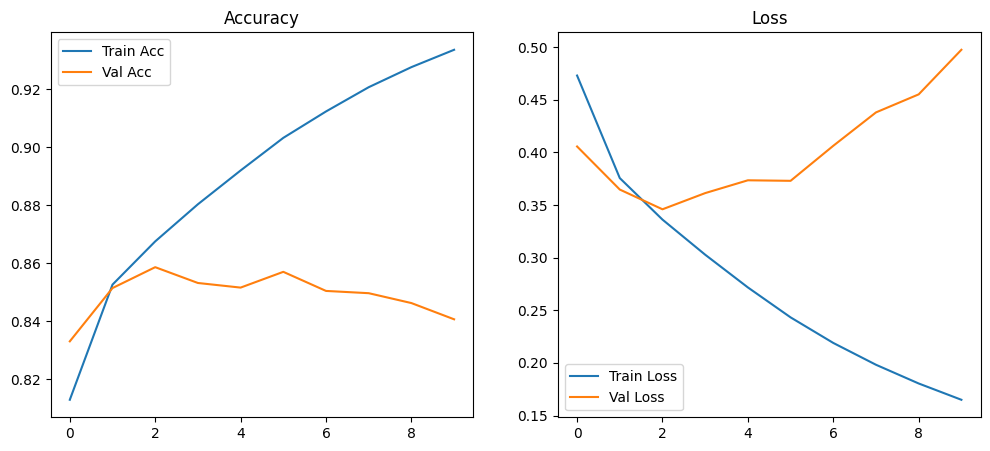

In [13]:
# Plotting acurrancy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.legend()
plt.show()


8411/8411 ━━━━━━━━━━━━━━━━━━━━ 202s 24ms/step
Classification Report:
              precision    recall  f1-score   support

    negative       0.94      0.86      0.90    153371
     neutral       0.70      0.79      0.74     65563
    positive       0.77      0.85      0.81     50212

    accuracy                           0.84    269146
   macro avg       0.80      0.83      0.82    269146
weighted avg       0.85      0.84      0.84    269146

Confusion Matrix:


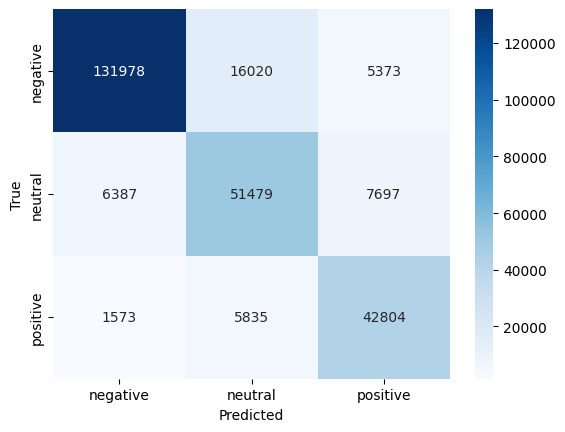

In [14]:
#Predicting and evaluating
y_pred = model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred, axis=1)

print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

print("Confusion Matrix:")
sns.heatmap(confusion_matrix(y_test, y_pred_classes), annot=True, fmt='d', cmap='Blues',xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
#Saving Classification Report in Json

#Converting predictions to class indices
y_pred_labels = np.argmax(y_pred, axis=1)

#Creating a label mapping update if the label encoding is different
label_mapping = {0: "negative", 1: "neutral", 2: "positive"}

#Converting indices to class names
y_pred_classes = [label_mapping[i] for i in y_pred_labels]

#Converting y_test to class names
y_test_classes = [label_mapping[i] if isinstance(i, int) else i for i in y_test]

#Generating classification report
labels = ["negative", "neutral", "positive"]
report = classification_report(y_test_classes, y_pred_classes, target_names=labels, output_dict=True)

#Saing it to JSON
with open("../results/bilstm_results_80_20.json", "w") as f:
    json.dump(report, f, indent=4)


In [ ]:
#Saving confusion matrix in png and csv
cm = confusion_matrix(y_test_classes, y_pred_classes, labels=labels)

#Saving the PNG image
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues")
plt.title("BiLSTM Confusion Matrix (80/20 Split)")
plt.savefig("../results/bilstm_confusion_matrix_80_20.png")
plt.close()

#Save CSV version
pd.DataFrame(cm, index=labels, columns=labels).to_csv("../results/bilstm_confusion_matrix_80_20.csv")

print("Confusion matrix saved as PNG and CSV.")

Confusion matrix saved as PNG and CSV.


In [31]:
#Predicting
y_pred_70_30 = model.predict(X_test_pad)
y_pred_labels_70_30 = np.argmax(y_pred_70_30, axis=1)

#Labels
label_map = {0: 'negative', 1: 'neutral', 2: 'positive'}
labels = ['negative', 'neutral', 'positive']

#Classification report
report_70_30 = classification_report(
    y_test, y_pred_labels_70_30, target_names=labels, output_dict=True
)
print(classification_report(y_test, y_pred_labels_70_30, target_names=labels))

#Saving report
with open("../results/bilstm/bilstm_results_70_30.json", "w") as f:
    json.dump(report_70_30, f, indent=4)

#Confusion Matrix
cm = confusion_matrix(y_test, y_pred_labels_70_30, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues")
plt.title("BiLSTM Confusion Matrix (70/30 Split)")
plt.savefig("../results/bilstm/bilstm_confusion_matrix_70_30.png")
plt.close()

#Saving as CSV
pd.DataFrame(cm, index=labels, columns=labels).to_csv("../results/bilstm/bilstm_confusion_matrix_70_30.csv")

print("BiLSTM 70/30 results saved.")

12617/12617 ━━━━━━━━━━━━━━━━━━━━ 293s 23ms/step
              precision    recall  f1-score   support

    negative       0.95      0.85      0.90    230057
     neutral       0.68      0.80      0.74     98344
    positive       0.78      0.84      0.81     75318

    accuracy                           0.84    403719
   macro avg       0.80      0.83      0.82    403719
weighted avg       0.85      0.84      0.84    403719

BiLSTM 70/30 results saved.


In [ ]:
#Predicting
y_pred_75_25 = model.predict(X_test_pad)
y_pred_labels_75_25 = np.argmax(y_pred_75_25, axis=1)

#Classification report
report_75_25 = classification_report(
    y_test, y_pred_labels_75_25, target_names=labels, output_dict=True
)
print(classification_report(y_test, y_pred_labels_75_25, target_names=labels))

#Saving to JSON report
with open("../results/bilstm/bilstm_results_75_25.json", "w") as f:
    json.dump(report_75_25, f, indent=4)

#Confusion matrix
cm = confusion_matrix(y_test, y_pred_labels_75_25, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues")
plt.title("BiLSTM Confusion Matrix (75/25 Split)")
plt.savefig("../results/bilstm/bilstm_confusion_matrix_75_25.png")
plt.close()

#Saving CSV
pd.DataFrame(cm, index=labels, columns=labels).to_csv("../results/bilstm/bilstm_confusion_matrix_75_25.csv")

print("BiLSTM 75/25 results saved.")


10514/10514 ━━━━━━━━━━━━━━━━━━━━ 242s 23ms/step
              precision    recall  f1-score   support

    negative       0.94      0.87      0.90    191714
     neutral       0.69      0.80      0.74     81953
    positive       0.80      0.83      0.82     62765

    accuracy                           0.84    336432
   macro avg       0.81      0.83      0.82    336432
weighted avg       0.85      0.84      0.85    336432

BiLSTM 75/25 results saved.


#### BiLSTM Model Implementation

In this notebook, we have implemented BiLSTM (Bidirectional Long Short-Term Memory) neural model where customer support messages are being classified, the reason why it was selected in this manner is that BiLSTM networks are particularly effective for understanding contextual information in sequential data which is this case with text classification tasks where order and dependencies matter.

The fact not to use the pre-generated BERT embeddings in the previous notebook is one of the most important choices. Those embeddings have been flattened, and stored as chunked formats and hence cannot be fed through the sequential input structure of the BiLSTM. Instead, we have used tokenised and padded sequence based upon raw text with the help of Tokenizer form Keras package which could introduce necessary structured data to the model.

The model structure was a non-trainable embedding layer, BiLSTM layer, dense layers, and a dropout as a regulariser. The results of training demonstrated that the BiLSTM led to competitive performance, more significantly it performed better than the PCA-based embeddings of conventional classifiers in handling the sequential nature of data. These results support the applicability of this architecture to deep learning part of the project and also confirms our decision to separate pipeline into ML and DL models.